In [1]:
import os,sys, pathlib, time, subprocess
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import re
from pathlib import Path
from scipy.interpolate import UnivariateSpline



folder_path = pathlib.Path().resolve()
planing_path = folder_path.parent.parent
problem_path = folder_path / "Problemas"
print("Current folder path:", folder_path)
print("Planing folder path:", planing_path)
print("Problem folder path:", problem_path)

sizes = []
times = []
steps = []
costs = []
step_pattern = re.compile(r"\s*\d+\s*:")
cost_pattern = re.compile(r"plan cost:\s*([0-9]+(?:\.[0-9]+)?)", re.IGNORECASE)





Current folder path: /home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2
Planing folder path: /home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani
Problem folder path: /home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/Problemas


# MetricFF

In [2]:

max_time = 60  # Tiempo máximo en segundos para cada resolución
size = 2
time_exceeded = False
max_size = 0


if not problem_path.exists():
    os.makedirs(problem_path)

pbar = tqdm(desc="Resolviendo tamaños", unit="problema", position=0, leave=True)
while not time_exceeded:
    pbar.set_description(f"Tamaño actual: {size}")
    # Generar el problema con los parámetros actuales
    gen_cmd = f"python3 {folder_path}/generate_problem.py -d 1 -r 1 -l {size} -p {size} -c {size} -g {size} -v 0"
    # pbar.write(f"\n[INFO] Generando problema para tamaño {size}...")
    os.system(gen_cmd)
    pddl_files = sorted(problem_path.glob("*.pddl"), key=os.path.getmtime, reverse=True)
    if not pddl_files:
        pbar.write("[ERROR] No se encontró el archivo .pddl generado.")
        break
    problem_pddl = pddl_files[0]
    planificador_cmd = [
        f"{planing_path}/planificadores/metricff",
        "-o", f"{folder_path}/dron-domain.pddl",
        "-f", str(problem_pddl)
    ]
    
    start = time.time()
    try:
        result = subprocess.run(planificador_cmd, timeout=max_time, capture_output=True, text=True)
        elapsed = time.time() - start
        if result.returncode == 0:
            max_size = size
            sizes.append(size)
            times.append(elapsed)
            result_lines = result.stdout.splitlines()
            step_count = 1
            for line in result.stdout.splitlines():
                if step_pattern.match(line):
                    step_count += 1
            cost_match = cost_pattern.search(result.stdout)
            if cost_match:
                cost = float(cost_match.group(1))
                costs.append(int(cost))
            else:
                cost = None
                costs.append(None)
            steps.append(step_count)
            
            pbar.write(f"[OK] Plan encontrado para tamaño {size} en {elapsed:.4f} segundos con {step_count} pasos.")
            pbar.set_postfix({"Tiempo": f"{elapsed:.2f}s", "Tamaño": size})
            size += 1
            pbar.update(1)
        else:
            time_exceeded = True
    except subprocess.TimeoutExpired:
        pbar.write(f"[TIMEOUT] Tiempo excedido ({max_time}s) para tamaño {size}.")
        time_exceeded = True
        
    os.remove(problem_pddl)

pbar.close()
print(f"\n>>> El mayor tamaño resuelto en menos de 1 minuto es: {max_size}")



Resolviendo tamaños: 0problema [00:00, ?problema/s]

[OK] Plan encontrado para tamaño 2 en 0.0034 segundos con 8 pasos.
[OK] Plan encontrado para tamaño 3 en 0.0030 segundos con 13 pasos.
[OK] Plan encontrado para tamaño 4 en 0.0040 segundos con 17 pasos.
[OK] Plan encontrado para tamaño 5 en 0.0049 segundos con 22 pasos.
[OK] Plan encontrado para tamaño 6 en 0.0073 segundos con 28 pasos.
[OK] Plan encontrado para tamaño 7 en 0.0089 segundos con 32 pasos.
[OK] Plan encontrado para tamaño 8 en 0.0126 segundos con 36 pasos.
[OK] Plan encontrado para tamaño 9 en 0.0161 segundos con 39 pasos.
[OK] Plan encontrado para tamaño 10 en 0.0248 segundos con 45 pasos.

>>> El mayor tamaño resuelto en menos de 1 minuto es: 10


In [3]:
print(sizes)
print(times)
print(steps)
print(costs)

[2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.0034406185150146484, 0.002977609634399414, 0.0040051937103271484, 0.0049440860748291016, 0.0073435306549072266, 0.008875846862792969, 0.0125732421875, 0.016109943389892578, 0.024814605712890625]
[8, 13, 17, 22, 28, 32, 36, 39, 45]
[500, 1165, 1052, 1181, 2395, 2401, 2643, 3688, 4512]


In [4]:
results_csv_path = folder_path / "Resultados/resultadosMetricff.csv"
if not results_csv_path.parent.exists():
    os.makedirs(results_csv_path.parent)

# Añadir la columna de costes
new_df = pd.DataFrame({'Tamaño': sizes, 'Tiempo (s)': times, 'Pasos': steps, 'Coste': costs})

if results_csv_path.exists():
    old_df = pd.read_csv(results_csv_path)
    # Si el archivo antiguo no tiene la columna 'Coste', la añadimos con NaN
    if 'Coste' not in old_df.columns:
        old_df['Coste'] = float('nan')
    combined_df = pd.concat([old_df, new_df], ignore_index=True)

    # Calcular la media de tiempo y coste por tamaño
    tiempo_df = combined_df.groupby('Tamaño', as_index=False)['Tiempo (s)'].mean()
    pasos_df = combined_df.groupby('Tamaño', as_index=False)['Pasos'].max()
    coste_df = combined_df.groupby('Tamaño', as_index=False)['Coste'].mean()

    # Unir todos los resultados en un solo DataFrame
    final_df = tiempo_df.merge(pasos_df, on='Tamaño').merge(coste_df, on='Tamaño')
else:
    final_df = new_df

final_df.to_csv(results_csv_path, index=False)
print(f"Resultados exportados a {results_csv_path}")


Resultados exportados a /home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/Resultados/resultadosMetricff.csv


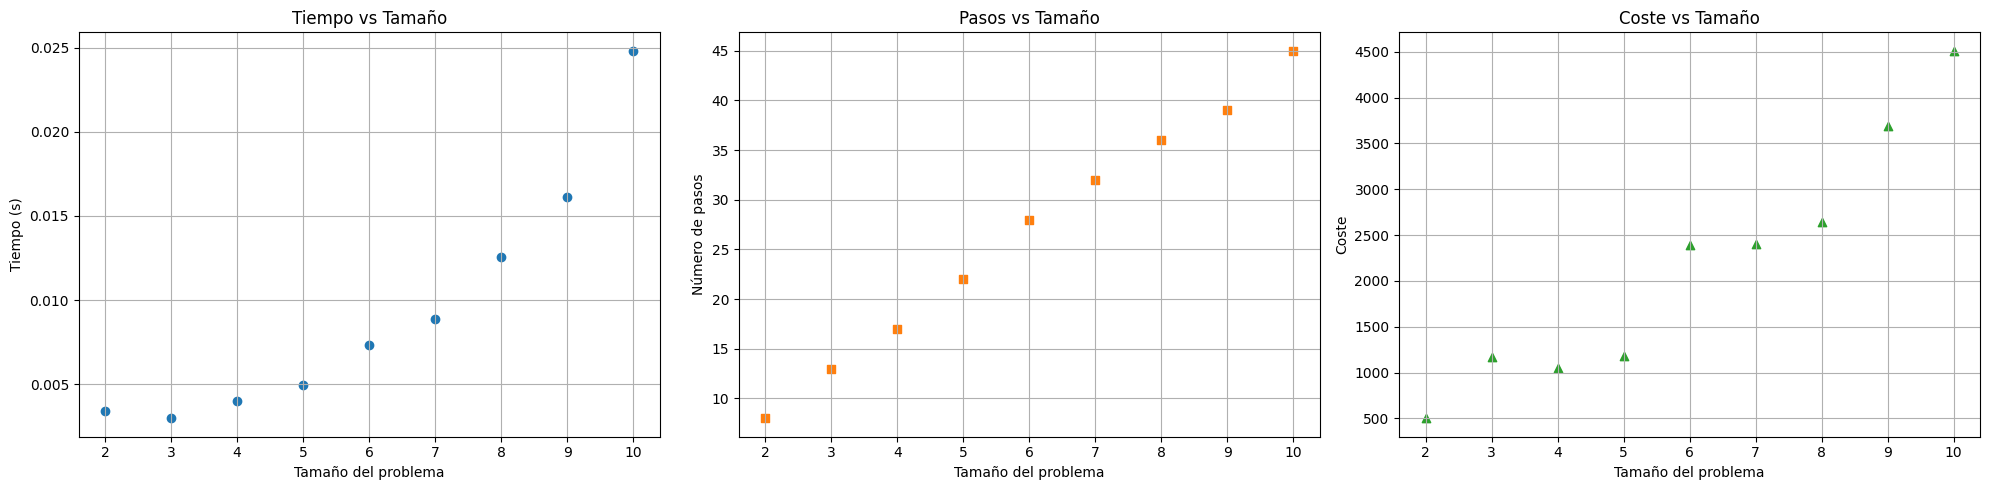

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Gráfico 1: Tiempo vs Tamaño
axs[0].scatter(sizes, times, marker='o', color='tab:blue')
axs[0].set_xlabel('Tamaño del problema')
axs[0].set_ylabel('Tiempo (s)')
axs[0].set_title('Tiempo vs Tamaño')
axs[0].grid(True)

# Gráfico 2: Pasos vs Tamaño
axs[1].scatter(sizes, steps, marker='s', color='tab:orange')
axs[1].set_xlabel('Tamaño del problema')
axs[1].set_ylabel('Número de pasos')
axs[1].set_title('Pasos vs Tamaño')
axs[1].grid(True)

# Gráfico 3: Coste vs Tamaño
axs[2].scatter(sizes, costs, marker='^', color='tab:green')
axs[2].set_xlabel('Tamaño del problema')
axs[2].set_ylabel('Coste')
axs[2].set_title('Coste vs Tamaño')
axs[2].grid(True)

plt.tight_layout()
plt.show()


# Lama First

In [6]:
planner_name = "Fastdownard-Lama"
sas_output_path = folder_path / "sas_plan"
# Remove --sas-file when using --alias
planner_cmd = [
    "/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/planificadores/downward.sif",
    "--alias", "lama-first",
    str(folder_path / "dron-domain.pddl")
    # problem_pddl will be appended later
]

max_time = 60
max_size = 0
sizes = []
times = []
steps_list = []
costs = []
outputs = []

size = 2
time_exceeded = False

if not problem_path.exists():
    os.makedirs(problem_path)

pbar = tqdm(desc="Resolviendo tamaños", unit="problema", position=0, leave=True)
while not time_exceeded:
    pbar.set_description(f"Tamaño actual: {size}")
    # Generar el problema con los parámetros actuales
    gen_cmd = f"python3 {folder_path}/generate_problem.py -d 1 -r 1 -l {size} -p {size} -c {size} -g {size} -v 0"
    os.system(gen_cmd)
    pddl_files = sorted(problem_path.glob("*.pddl"), key=os.path.getmtime, reverse=True)
    if not pddl_files:
        break
    problem_pddl = pddl_files[0]
    
    # Construir el comando completo para el planificador
    full_cmd = planner_cmd + [str(problem_pddl)]
    
    pddl_files = sorted(
        problem_path.glob("*.pddl"),
        key=os.path.getmtime,
        reverse=True
    )
    
    if not pddl_files:
        pbar.write("[ERROR] No se encontró el archivo .pddl generado.")
        break
    problem_pddl = pddl_files[0]

    pbar.set_postfix({"Planificador": planner_name, "Tamaño": size})

    start = time.time()
    try:
        result = subprocess.run(full_cmd, timeout=max_time, capture_output=True, text=True)
        elapsed = time.time() - start
        if result.returncode == 0:
            plan_output = sas_output_path.read_text().strip()
            # Contar líneas válidas de plan (ignorando comentarios)
            num_steps = sum(
                1
                for line in plan_output.strip().split("\n")
                if line.strip() and not line.startswith(";") and "(" in line
            )

            # Leer el coste del plan si existe
            plan_cost = None
            for line in plan_output.splitlines():
                line = line.strip()
                if line.startswith(";") and "cost" in line:
                    # Formato esperado: ; cost = 12808 (general cost)
                    try:
                        plan_cost = float(line.split("=")[1].split()[0])
                    except Exception:
                        plan_cost = None
                    break

            sizes.append(size)
            times.append(elapsed)
            steps_list.append(num_steps - 1)
            costs.append(plan_cost)
            outputs.append(plan_output[:500])  # guardar solo primeros 500 caracteres
            max_size = size
            
        else:
            pbar.write(f"[ERROR] Planificador {planner_name} falló para tamaño {size}.")
            print(f"Salida del planificador:\n{result.stdout}")
            time_exceeded = True
            break
    except Exception as e:
        pbar.write(f"[ERROR] Excepción al ejecutar el planificador: {e}")
        time_exceeded = True
        break
    pbar.update(1)
    size += 1
    os.remove(problem_pddl)
pbar.close()

print("\n=== Resumen de resultados ===\n")
print(f"Tamaño máximo resuelto por {planner_name}: {max_size}")

csv_path = folder_path / f"Resultados/resultados_{planner_name.lower()}.csv"
df = pd.DataFrame({
    "Tamaño": sizes,
    "Tiempo (s)": times,
    "Pasos": steps_list,
    "Coste": costs
})

df.to_csv(csv_path, index=False)
print(f"Resultados de {planner_name} exportados a {csv_path}")

if sizes:
    df_display = pd.DataFrame({
        "Tamaño": sizes,
        "Tiempo (s)": times,
        "Pasos plan": steps_list,
        "Coste": costs,
        "Planificador": planner_name
    })
    display(df_display)

if outputs:
    max_idx = sizes.index(max_size)
    print(f"\nSalida fragmento para {planner_name} tamaño {max_size}:\n")
    print(outputs[max_idx])


Resolviendo tamaños: 0problema [00:00, ?problema/s]

[ERROR] Excepción al ejecutar el planificador: Command '['/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/planificadores/downward.sif', '--alias', 'lama-first', '/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/dron-domain.pddl', '/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/Problemas/drone_problem_d1_r1_l96_p96_c96_g96_ct2.pddl']' timed out after 60 seconds

=== Resumen de resultados ===

Tamaño máximo resuelto por Fastdownard-Lama: 95
Resultados de Fastdownard-Lama exportados a /home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/Resultados/resultados_fastdownard-lama.csv


,Tamaño,Tiempo (s),Pasos plan,Coste,Planificador
0,2,0.402262,7,864.0,Fastdownard-Lama
1,3,0.405030,11,420.0,Fastdownard-Lama
2,4,0.418771,15,1456.0,Fastdownard-Lama
3,5,0.428755,19,1294.0,Fastdownard-Lama
4,6,0.438501,23,1402.0,Fastdownard-Lama
...,...,...,...,...,...
89,91,33.442262,363,28070.0,Fastdownard-Lama
90,92,39.455584,367,25200.0,Fastdownard-Lama
91,93,38.833546,371,28388.0,Fastdownard-Lama
92,94,41.520824,375,32206.0,Fastdownard-Lama



Salida fragmento para Fastdownard-Lama tamaño 95:

(cargar_dron dron1 crate9 deposito)
(mover-dron dron1 deposito loc10)
(entregar person25 crate9 comida loc10 dron1)
(mover-dron dron1 loc10 deposito)
(cargar_dron dron1 crate8 deposito)
(mover-dron dron1 deposito loc12)
(entregar person22 crate8 comida loc12 dron1)
(mover-dron dron1 loc12 deposito)
(cargar_dron dron1 crate7 deposito)
(mover-dron dron1 deposito loc15)
(entregar person7 crate7 comida loc15 dron1)
(mover-dron dron1 loc15 deposito)
(cargar_dron dron1 crate6 deposito)
(mover-dron dro


In [7]:
print("\n=== Resumen de resultados ===\n")
print(f"Tamaño máximo resuelto por {planner_name}: {max_size}")

csv_path = folder_path / f"Resultados/resultados_{planner_name.lower()}.csv"
df = pd.DataFrame({
    "Tamaño": sizes,
    "Tiempo (s)": times,
    "Pasos": steps_list,
    "Coste": costs
})
if csv_path.exists():
    old_df = pd.read_csv(csv_path)
    combined_df = pd.concat([old_df, df], ignore_index=True)
    final_df = combined_df.groupby('Tamaño', as_index=False)['Tiempo (s)'].mean()
    if 'Pasos' in combined_df.columns:
        pasos_df = combined_df.groupby('Tamaño', as_index=False)['Pasos'].max()
        final_df = final_df.merge(pasos_df, on='Tamaño')
    if 'Coste' in combined_df.columns:
        coste_df = combined_df.groupby('Tamaño', as_index=False)['Coste'].mean()
        final_df = final_df.merge(coste_df, on='Tamaño')
else:
    final_df = df
final_df.to_csv(csv_path, index=False)
print(f"Resultados de {planner_name} exportados a {csv_path}")

if sizes:
    df_display = pd.DataFrame({
        "Tamaño": sizes,
        "Tiempo (s)": times,
        "Pasos plan": steps_list,
        "Coste": costs,
        "Planificador": planner_name
    })
    display(df_display)

if outputs:
    max_idx = sizes.index(max_size)
    print(f"\nSalida fragmento para {planner_name} tamaño {max_size}:\n")
    print(outputs[max_idx])


=== Resumen de resultados ===

Tamaño máximo resuelto por Fastdownard-Lama: 95
Resultados de Fastdownard-Lama exportados a /home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/Resultados/resultados_fastdownard-lama.csv


,Tamaño,Tiempo (s),Pasos plan,Coste,Planificador
0,2,0.402262,7,864.0,Fastdownard-Lama
1,3,0.405030,11,420.0,Fastdownard-Lama
2,4,0.418771,15,1456.0,Fastdownard-Lama
3,5,0.428755,19,1294.0,Fastdownard-Lama
4,6,0.438501,23,1402.0,Fastdownard-Lama
...,...,...,...,...,...
89,91,33.442262,363,28070.0,Fastdownard-Lama
90,92,39.455584,367,25200.0,Fastdownard-Lama
91,93,38.833546,371,28388.0,Fastdownard-Lama
92,94,41.520824,375,32206.0,Fastdownard-Lama



Salida fragmento para Fastdownard-Lama tamaño 95:

(cargar_dron dron1 crate9 deposito)
(mover-dron dron1 deposito loc10)
(entregar person25 crate9 comida loc10 dron1)
(mover-dron dron1 loc10 deposito)
(cargar_dron dron1 crate8 deposito)
(mover-dron dron1 deposito loc12)
(entregar person22 crate8 comida loc12 dron1)
(mover-dron dron1 loc12 deposito)
(cargar_dron dron1 crate7 deposito)
(mover-dron dron1 deposito loc15)
(entregar person7 crate7 comida loc15 dron1)
(mover-dron dron1 loc15 deposito)
(cargar_dron dron1 crate6 deposito)
(mover-dron dro


In [8]:
print(sizes)
print(times)
print(steps_list)
print(costs)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
[0.40226221084594727, 0.4050304889678955, 0.41877079010009766, 0.4287552833557129, 0.43850135803222656, 0.4738309383392334, 0.5110483169555664, 0.5298397541046143, 0.5632236003875732, 0.6140673160552979, 0.6363525390625, 0.6872220039367676, 0.7021784782409668, 0.7208600044250488, 0.7631573677062988, 0.8136272430419922, 0.869560718536377, 0.9191188812255859, 1.014756202697754, 1.0502488613128662, 1.18507981300354, 1.2061140537261963, 1.373986005783081, 1.4293758869171143, 1.5119507312774658, 1.5987157821655273, 1.6615114212036133, 1.7851836681365967, 1.9104115962982178, 2.1135706901550293, 2.329338550567627, 2.26185441017150

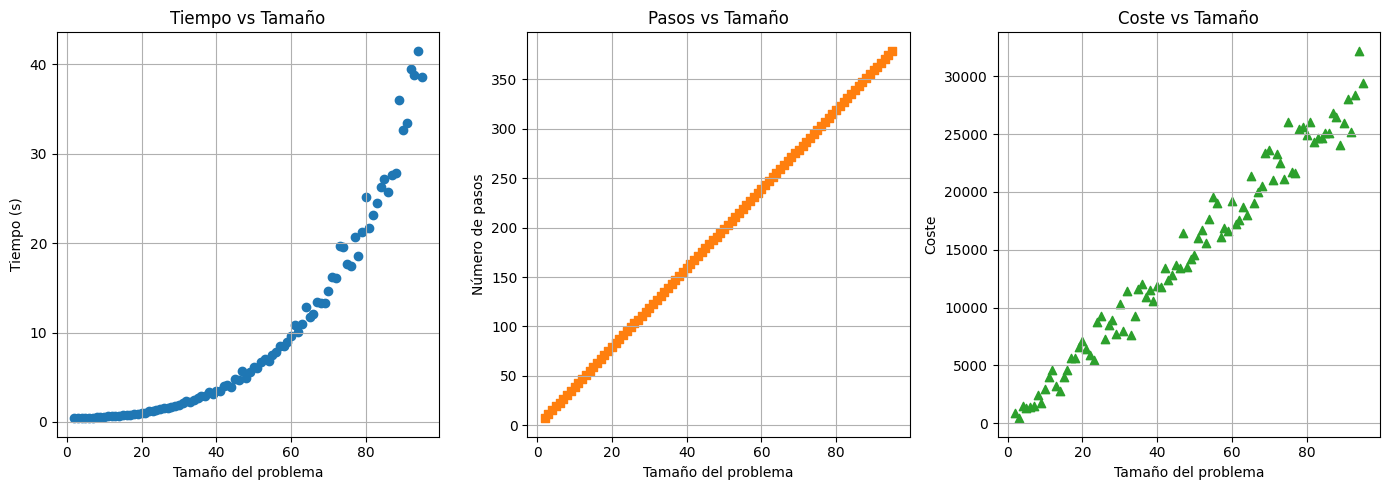

In [9]:
# Cargar los datos desde el archivo CSV exportado
results = pd.read_csv(folder_path / "Resultados/resultados_fastdownard-lama.csv")

sizes = results['Tamaño']
times = results['Tiempo (s)']
steps = results['Pasos']

fig, axs = plt.subplots(1, 3, figsize=(14, 5))

# Gráfico 1: Tiempo vs Tamaño (sin líneas entre puntos)
axs[0].scatter(sizes, times, marker='o', color='tab:blue')


axs[0].set_xlabel('Tamaño del problema')
axs[0].set_ylabel('Tiempo (s)')
axs[0].set_title('Tiempo vs Tamaño')
axs[0].grid(True)

# Gráfico 2: Pasos vs Tamaño (sin líneas entre puntos)
axs[1].scatter(sizes, steps, marker='s', color='tab:orange')

axs[1].set_xlabel('Tamaño del problema')
axs[1].set_ylabel('Número de pasos')
axs[1].set_title('Pasos vs Tamaño')
axs[1].grid(True)

axs[2].scatter(sizes, costs, marker='^', color='tab:green')
axs[2].set_xlabel('Tamaño del problema')
axs[2].set_ylabel('Coste')
axs[2].set_title('Coste vs Tamaño')
axs[2].grid(True)

plt.tight_layout()
plt.show()


# Autotune 2

In [10]:
planner_name = "Fastdownard-Autotune 2"
sas_output_path = folder_path / "sas_plan"
# Remove --sas-file when using --alias
planner_cmd = [
    "/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/planificadores/downward.sif",
    "--alias", "seq-sat-fd-autotune-2", "--plan-file", str(sas_output_path),
    str(folder_path / "dron-domain.pddl")
    # problem_pddl will be appended later
]


max_time = 60
max_size = 0
sizes = []
times = []
steps_list = []
costs = []
outputs = []

size = 2
time_exceeded = False

if not problem_path.exists():
    os.makedirs(problem_path)

pbar = tqdm(desc="Resolviendo tamaños", unit="problema", position=0, leave=True)
while not time_exceeded:
    pbar.set_description(f"Tamaño actual: {size}")
    # Generar el problema con los parámetros actuales
    gen_cmd = f"python3 {folder_path}/generate_problem.py -d 1 -r 1 -l {size} -p {size} -c {size} -g {size} -v 0"
    os.system(gen_cmd)
    pddl_files = sorted(problem_path.glob("*.pddl"), key=os.path.getmtime, reverse=True)
    if not pddl_files:
        break
    problem_pddl = pddl_files[0]
    
    # Construir el comando completo para el planificador
    full_cmd = planner_cmd + [str(problem_pddl)]
    
    pddl_files = sorted(
        problem_path.glob("*.pddl"),
        key=os.path.getmtime,
        reverse=True
    )
    
    if not pddl_files:
        pbar.write("[ERROR] No se encontró el archivo .pddl generado.")
        break
    problem_pddl = pddl_files[0]

    pbar.set_postfix({"Planificador": planner_name, "Tamaño": size})

    start = time.time()
    try:
        result = subprocess.run(full_cmd, timeout=max_time, capture_output=True, text=True)
        elapsed = time.time() - start
        if result.returncode == 0:
    # Encontrar el último archivo sas_plan generado
            sas_files = sorted(
                folder_path.glob("sas_plan*"),
                key=lambda f: int(f.name.split(".")[-1]) if f.name != "sas_plan" else 0,
                reverse=True
            )
            
            if not sas_files:
                pbar.write("[ERROR] No se encontró archivo de plan")
                continue
            
            latest_sas = sas_files[0]
            
            # Leer y procesar el último plan
            plan_output = latest_sas.read_text().strip()
            
            # Contar pasos válidos
            num_steps = sum(
                1 for line in plan_output.split("\n")
                if line.strip() and not line.startswith(";") and "(" in line
            )
            
            # Extraer coste del plan
            plan_cost = None
            for line in plan_output.splitlines():
                if line.startswith(";") and "cost" in line:
                    try:
                        plan_cost = float(line.split("=")[1].split()[0].strip())
                    except (IndexError, ValueError):
                        pass
                    break
                    
            # Eliminar el archivo después de procesarlo
            sizes.append(size)
            times.append(elapsed)
            steps_list.append(num_steps - 1)
            costs.append(plan_cost)
            outputs.append(plan_output)  # guardar solo primeros 500 caracteres
            max_size = size
            
        else:
            pbar.write(f"[ERROR] Planificador {planner_name} falló para tamaño {size}.")
            print(f"Salida del planificador:\n{result.stdout}")
            time_exceeded = True
            break
    except Exception as e:
        pbar.write(f"[ERROR] Excepción al ejecutar el planificador: {e}")
        time_exceeded = True
        break
    pbar.update(1)
    size += 1
    os.remove(problem_pddl)
pbar.close()

print("\n=== Resumen de resultados ===\n")
print(f"Tamaño máximo resuelto por {planner_name}: {max_size}")

csv_path = folder_path / f"Resultados/resultados_{planner_name.lower()}.csv"
df = pd.DataFrame({
    "Tamaño": sizes,
    "Tiempo (s)": times,
    "Pasos": steps_list,
    "Coste": costs
})

df.to_csv(csv_path, index=False)
print(f"Resultados de {planner_name} exportados a {csv_path}")

if sizes:
    df_display = pd.DataFrame({
        "Tamaño": sizes,
        "Tiempo (s)": times,
        "Pasos plan": steps_list,
        "Coste": costs,
        "Planificador": planner_name
    })
    display(df_display)

if outputs:
    max_idx = sizes.index(max_size)
    print(f"\nSalida fragmento para {planner_name} tamaño {max_size}:\n")
    print(outputs[max_idx])



Resolviendo tamaños: 0problema [00:00, ?problema/s]

[ERROR] Excepción al ejecutar el planificador: Command '['/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/planificadores/downward.sif', '--alias', 'seq-sat-fd-autotune-2', '--plan-file', '/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/sas_plan', '/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/dron-domain.pddl', '/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/Problemas/drone_problem_d1_r1_l7_p7_c7_g7_ct2.pddl']' timed out after 60 seconds

=== Resumen de resultados ===

Tamaño máximo resuelto por Fastdownard-Autotune 2: 6
Resultados de Fastdownard-Autotune 2 exportados a /home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/Resultados/resultados_fastdownard-autotune 2.csv


,Tamaño,Tiempo (s),Pasos plan,Coste,Planificador
0,2,0.441577,7,764.0,Fastdownard-Autotune 2
1,3,0.457845,11,1368.0,Fastdownard-Autotune 2
2,4,0.734282,15,1436.0,Fastdownard-Autotune 2
3,5,1.237882,19,1698.0,Fastdownard-Autotune 2
4,6,15.713121,23,1484.0,Fastdownard-Autotune 2



Salida fragmento para Fastdownard-Autotune 2 tamaño 6:

(cargar_dron dron1 crate5 deposito)
(mover-dron dron1 deposito loc3)
(entregar person1 crate5 medicina loc3 dron1)
(mover-dron dron1 loc3 deposito)
(cargar_dron dron1 crate6 deposito)
(mover-dron dron1 deposito loc4)
(entregar person5 crate6 medicina loc4 dron1)
(mover-dron dron1 loc4 deposito)
(cargar_dron dron1 crate1 deposito)
(mover-dron dron1 deposito loc5)
(entregar person6 crate1 comida loc5 dron1)
(mover-dron dron1 loc5 deposito)
(cargar_dron dron1 crate4 deposito)
(mover-dron dron1 deposito loc5)
(entregar person3 crate4 medicina loc5 dron1)
(mover-dron dron1 loc5 deposito)
(cargar_dron dron1 crate3 deposito)
(mover-dron dron1 deposito loc5)
(entregar person4 crate3 medicina loc5 dron1)
(mover-dron dron1 loc5 deposito)
(cargar_dron dron1 crate2 deposito)
(mover-dron dron1 deposito loc5)
(entregar person6 crate2 medicina loc5 dron1)
(mover-dron dron1 loc5 deposito)
; cost = 1484 (general cost)


In [11]:
print(costs)

[764.0, 1368.0, 1436.0, 1698.0, 1484.0]



=== Resumen de resultados ===

Tamaño máximo resuelto por Fastdownard-Autotune 2: 6
Resultados de Fastdownard-Autotune 2 exportados a /home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/Resultados/resultados_fastdownard-autotune 2.csv


,Tamaño,Tiempo (s),Pasos plan,Coste,Planificador
0,2,0.441577,7,764.0,Fastdownard-Autotune 2
1,3,0.457845,11,1368.0,Fastdownard-Autotune 2
2,4,0.734282,15,1436.0,Fastdownard-Autotune 2
3,5,1.237882,19,1698.0,Fastdownard-Autotune 2
4,6,15.713121,23,1484.0,Fastdownard-Autotune 2


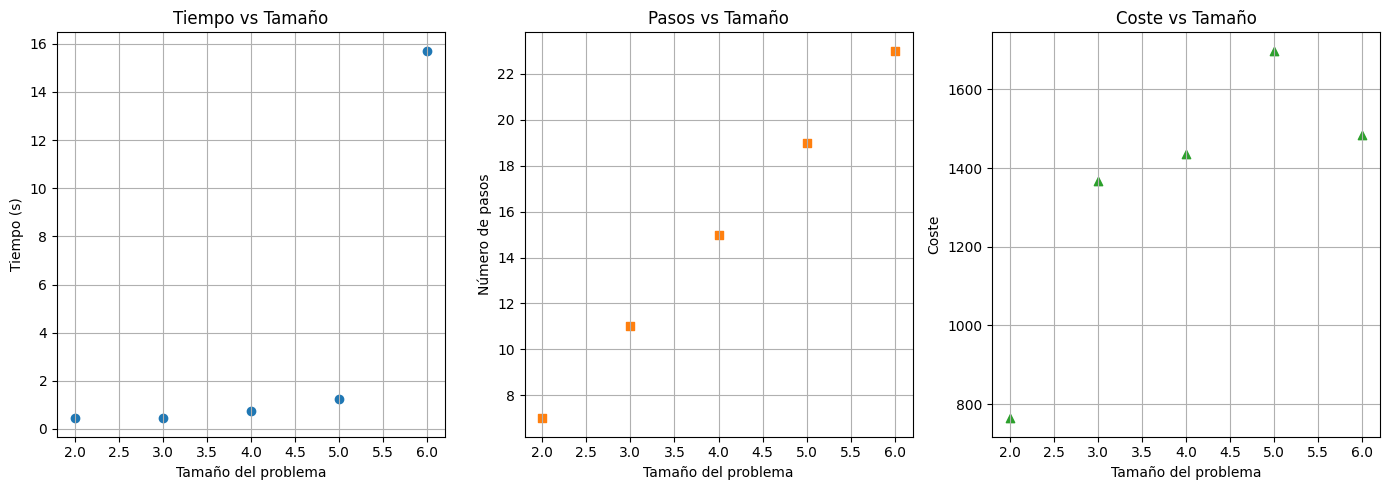

In [12]:
print("\n=== Resumen de resultados ===\n")
print(f"Tamaño máximo resuelto por {planner_name}: {max_size}")

csv_path = folder_path / f"Resultados/resultados_{planner_name.lower()}.csv"
df = pd.DataFrame({
    "Tamaño": sizes,
    "Tiempo (s)": times,
    "Pasos": steps_list,
    "Coste": costs
})
if csv_path.exists():
    old_df = pd.read_csv(csv_path)
    combined_df = pd.concat([old_df, df], ignore_index=True)
    final_df = combined_df.groupby('Tamaño', as_index=False)['Tiempo (s)'].mean()
    if 'Pasos' in combined_df.columns:
        pasos_df = combined_df.groupby('Tamaño', as_index=False)['Pasos'].max()
        final_df = final_df.merge(pasos_df, on='Tamaño')
    if 'Coste' in combined_df.columns:
        coste_df = combined_df.groupby('Tamaño', as_index=False)['Coste'].mean()
        final_df = final_df.merge(coste_df, on='Tamaño')
else:
    final_df = df
final_df.to_csv(csv_path, index=False)
print(f"Resultados de {planner_name} exportados a {csv_path}")

df_display = pd.DataFrame({
    "Tamaño": sizes,
    "Tiempo (s)": times,
    "Pasos plan": steps_list,
    "Coste": costs,
    "Planificador": planner_name
})
display(df_display)



# Cargar los datos desde el archivo CSV exportado
results = pd.read_csv(csv_path)

sizes = results['Tamaño']
times = results['Tiempo (s)']
steps = results['Pasos']
if 'Coste' in results.columns:
    costs = results['Coste']
else:
    import numpy as np
    costs = np.full(len(sizes), np.nan)

fig, axs = plt.subplots(1, 3, figsize=(14, 5))

# Gráfico 1: Tiempo vs Tamaño (sin líneas entre puntos)
axs[0].scatter(sizes, times, marker='o', color='tab:blue')
axs[0].set_xlabel('Tamaño del problema')
axs[0].set_ylabel('Tiempo (s)')
axs[0].set_title('Tiempo vs Tamaño')
axs[0].grid(True)

# Gráfico 2: Pasos vs Tamaño (sin líneas entre puntos)
axs[1].scatter(sizes, steps, marker='s', color='tab:orange')
axs[1].set_xlabel('Tamaño del problema')
axs[1].set_ylabel('Número de pasos')
axs[1].set_title('Pasos vs Tamaño')
axs[1].grid(True)

# Gráfico 3: Coste vs Tamaño
axs[2].scatter(sizes, costs, marker='^', color='tab:green')
axs[2].set_xlabel('Tamaño del problema')
axs[2].set_ylabel('Coste')
axs[2].set_title('Coste vs Tamaño')
axs[2].grid(True)

plt.tight_layout()
plt.show()


# Stone Soup 2 Satisficing version 

In [13]:
planner_name = "Fastdownard-seq-sat-fdss-2"
sas_output_path = folder_path / "sas_plan"
# Remove --sas-file when using --alias
planner_cmd = [
    "/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/planificadores/downward.sif",
    "--alias", "seq-sat-fdss-2", "--plan-file", str(sas_output_path),
    str(folder_path / "dron-domain.pddl")
    # problem_pddl will be appended later
]


max_time = 60
max_size = 0
sizes = []
times = []
steps_list = []
costs = []
outputs = []

size = 2
time_exceeded = False

if not problem_path.exists():
    os.makedirs(problem_path)

pbar = tqdm(desc="Resolviendo tamaños", unit="problema", position=0, leave=True)
while not time_exceeded:
    pbar.set_description(f"Tamaño actual: {size}")
    # Generar el problema con los parámetros actuales
    gen_cmd = f"python3 {folder_path}/generate_problem.py -d 1 -r 1 -l {size} -p {size} -c {size} -g {size} -v 0"
    os.system(gen_cmd)
    pddl_files = sorted(problem_path.glob("*.pddl"), key=os.path.getmtime, reverse=True)
    if not pddl_files:
        break
    problem_pddl = pddl_files[0]
    
    # Construir el comando completo para el planificador
    full_cmd = planner_cmd + [str(problem_pddl)]
    
    pddl_files = sorted(
        problem_path.glob("*.pddl"),
        key=os.path.getmtime,
        reverse=True
    )
    
    if not pddl_files:
        pbar.write("[ERROR] No se encontró el archivo .pddl generado.")
        break
    problem_pddl = pddl_files[0]

    pbar.set_postfix({"Planificador": planner_name, "Tamaño": size})

    start = time.time()
    try:
        result = subprocess.run(full_cmd, timeout=max_time, capture_output=True, text=True)
        elapsed = time.time() - start
        if result.returncode == 0:
    # Encontrar el último archivo sas_plan generado
            sas_files = sorted(
                folder_path.glob("sas_plan*"),
                key=lambda f: int(f.name.split(".")[-1]) if f.name != "sas_plan" else 0,
                reverse=True
            )
            
            if not sas_files:
                pbar.write("[ERROR] No se encontró archivo de plan")
                continue
            
            latest_sas = sas_files[0]
            
            # Leer y procesar el último plan
            plan_output = latest_sas.read_text().strip()
            
            # Contar pasos válidos
            num_steps = sum(
                1 for line in plan_output.split("\n")
                if line.strip() and not line.startswith(";") and "(" in line
            )
            
            # Extraer coste del plan
            plan_cost = None
            for line in plan_output.splitlines():
                if line.startswith(";") and "cost" in line:
                    try:
                        plan_cost = float(line.split("=")[1].split()[0].strip())
                    except (IndexError, ValueError):
                        pass
                    break
                    
            # Eliminar el archivo después de procesarlo
            sizes.append(size)
            times.append(elapsed)
            steps_list.append(num_steps - 1)
            costs.append(plan_cost)
            outputs.append(plan_output)  # guardar solo primeros 500 caracteres
            max_size = size
            
        else:
            pbar.write(f"[ERROR] Planificador {planner_name} falló para tamaño {size}.")
            print(f"Salida del planificador:\n{result.stdout}")
            time_exceeded = True
            break
    except Exception as e:
        pbar.write(f"[ERROR] Excepción al ejecutar el planificador: {e}")
        time_exceeded = True
        break
    pbar.update(1)
    size += 1
    os.remove(problem_pddl)
pbar.close()

print("\n=== Resumen de resultados ===\n")
print(f"Tamaño máximo resuelto por {planner_name}: {max_size}")

csv_path = folder_path / f"Resultados/resultados_{planner_name.lower()}.csv"
df = pd.DataFrame({
    "Tamaño": sizes,
    "Tiempo (s)": times,
    "Pasos": steps_list,
    "Coste": costs
})

df.to_csv(csv_path, index=False)
print(f"Resultados de {planner_name} exportados a {csv_path}")

if sizes:
    df_display = pd.DataFrame({
        "Tamaño": sizes,
        "Tiempo (s)": times,
        "Pasos plan": steps_list,
        "Coste": costs,
        "Planificador": planner_name
    })
    display(df_display)

if outputs:
    max_idx = sizes.index(max_size)
    print(f"\nSalida fragmento para {planner_name} tamaño {max_size}:\n")
    print(outputs[max_idx])



Resolviendo tamaños: 0problema [00:00, ?problema/s]

[ERROR] Planificador Fastdownard-seq-sat-fdss-2 falló para tamaño 2.
Salida del planificador:
INFO     Running translator.
INFO     translator stdin: None
INFO     translator time limit: None
INFO     translator memory limit: None
INFO     translator command line string: /usr/bin/python3 /workspace/downward/builds/release/bin/translate/translate.py /home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/dron-domain.pddl /home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/Problemas/drone_problem_d1_r1_l2_p2_c2_g2_ct2.pddl --sas-file output.sas
Parsing...
Parsing: [0.000s CPU, 0.002s wall-clock]
Normalizing task... [0.000s CPU, 0.000s wall-clock]
Instantiating...
Generating Datalog program... [0.000s CPU, 0.000s wall-clock]
Normalizing Datalog program...
Normalizing Datalog program: [0.010s CPU, 0.004s wall-clock]
Preparing model... [0.000s CPU, 0.001s wall-clock]
Generated 69 rules.
Computing model... [0.000s CPU, 0.003s wall-clock]
156 releva


=== Resumen de resultados ===

Tamaño máximo resuelto por Fastdownard-seq-sat-fdss-2: 0
Resultados de Fastdownard-seq-sat-fdss-2 exportados a /home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/Resultados/resultados_fastdownard-seq-sat-fdss-2.csv


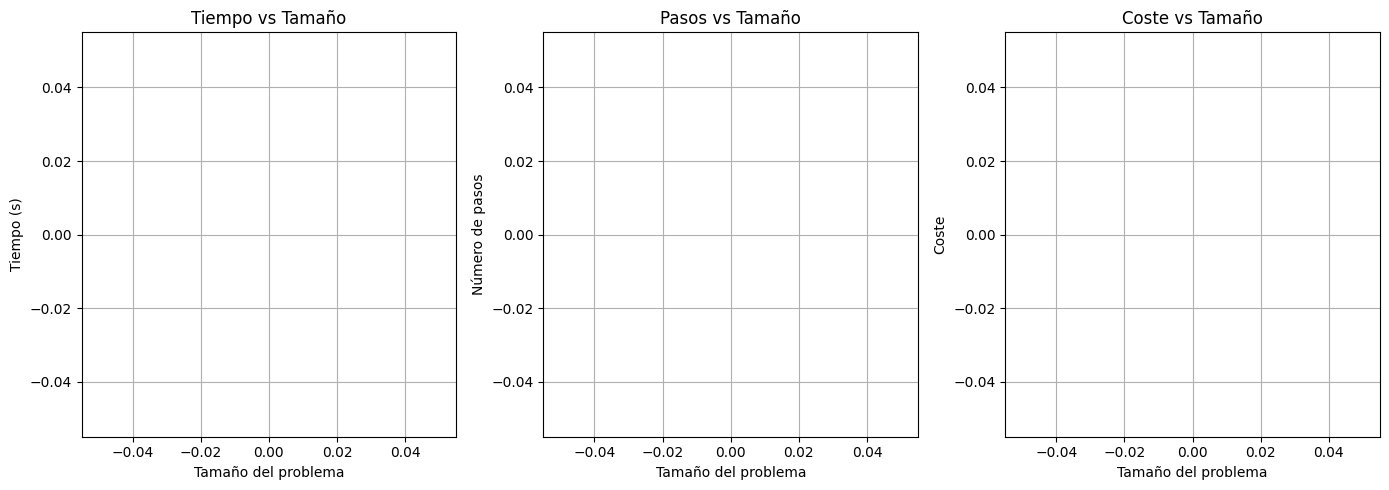

In [14]:
print("\n=== Resumen de resultados ===\n")
print(f"Tamaño máximo resuelto por {planner_name}: {max_size}")

csv_path = folder_path / f"Resultados/resultados_{planner_name.lower()}.csv"
df = pd.DataFrame({
    "Tamaño": sizes,
    "Tiempo (s)": times,
    "Pasos": steps_list
})
if csv_path.exists():
    old_df = pd.read_csv(csv_path)
    combined_df = pd.concat([old_df, df], ignore_index=True)
    final_df = combined_df.groupby('Tamaño', as_index=False)['Tiempo (s)'].mean()
    if 'Pasos' in combined_df.columns:
        pasos_df = combined_df.groupby('Tamaño', as_index=False)['Pasos'].max()
        final_df = final_df.merge(pasos_df, on='Tamaño')
else:
    final_df = df
final_df.to_csv(csv_path, index=False)
print(f"Resultados de {planner_name} exportados a {csv_path}")

if sizes:
    df_display = pd.DataFrame({
        "Tamaño": sizes,
        "Tiempo (s)": times,
        "Pasos plan": steps_list,
        "Planificador": planner_name
    })
    display(df_display)

if outputs:
    max_idx = sizes.index(max_size)
    print(f"\nSalida fragmento para {planner_name} tamaño {max_size}:\n")
    print(outputs[max_idx])


# Cargar los datos desde el archivo CSV exportado
results = pd.read_csv(csv_path)

sizes = results['Tamaño']
times = results['Tiempo (s)']
steps = results['Pasos']

# Manejar la columna de coste si existe
if 'Coste' in results.columns:
    costs = results['Coste']
else:
    import numpy as np
    costs = np.full(len(sizes), np.nan)

fig, axs = plt.subplots(1, 3, figsize=(14, 5))

# Gráfico 1: Tiempo vs Tamaño (sin líneas entre puntos)
axs[0].scatter(sizes, times, marker='o', color='tab:blue')


axs[0].set_xlabel('Tamaño del problema')
axs[0].set_ylabel('Tiempo (s)')
axs[0].set_title('Tiempo vs Tamaño')
axs[0].grid(True)

# Gráfico 2: Pasos vs Tamaño (sin líneas entre puntos)
axs[1].scatter(sizes, steps, marker='s', color='tab:orange')

axs[1].set_xlabel('Tamaño del problema')
axs[1].set_ylabel('Número de pasos')
axs[1].set_title('Pasos vs Tamaño')
axs[1].grid(True)

axs[2].scatter(sizes, costs, marker='^', color='tab:green')
axs[2].set_xlabel('Tamaño del problema')
axs[2].set_ylabel('Coste')
axs[2].set_title('Coste vs Tamaño')
axs[2].grid(True)

plt.tight_layout()
plt.show()



# seq-opt-lmcut

In [15]:
planner_name = "Fastdownard-seq-opt-lmcut"
sas_output_path = folder_path / "sas_plan"
# Remove --sas-file when using --alias
planner_cmd = [
    "/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/planificadores/downward.sif",
    "--alias", "seq-opt-lmcut", "--plan-file", str(sas_output_path),
    str(folder_path / "dron-domain.pddl")
    # problem_pddl will be appended later
]


max_time = 60
max_size = 0
sizes = []
times = []
steps_list = []
costs = []
outputs = []

size = 2
time_exceeded = False

if not problem_path.exists():
    os.makedirs(problem_path)

pbar = tqdm(desc="Resolviendo tamaños", unit="problema", position=0, leave=True)
while not time_exceeded:
    pbar.set_description(f"Tamaño actual: {size}")
    # Generar el problema con los parámetros actuales
    gen_cmd = f"python3 {folder_path}/generate_problem.py -d 1 -r 1 -l {size} -p {size} -c {size} -g {size} -v 0"
    os.system(gen_cmd)
    pddl_files = sorted(problem_path.glob("*.pddl"), key=os.path.getmtime, reverse=True)
    if not pddl_files:
        break
    problem_pddl = pddl_files[0]
    
    # Construir el comando completo para el planificador
    full_cmd = planner_cmd + [str(problem_pddl)]
    
    pddl_files = sorted(
        problem_path.glob("*.pddl"),
        key=os.path.getmtime,
        reverse=True
    )
    
    if not pddl_files:
        pbar.write("[ERROR] No se encontró el archivo .pddl generado.")
        break
    problem_pddl = pddl_files[0]

    pbar.set_postfix({"Planificador": planner_name, "Tamaño": size})

    start = time.time()
    try:
        result = subprocess.run(full_cmd, timeout=max_time, capture_output=True, text=True)
        elapsed = time.time() - start
        if result.returncode == 0:
    # Encontrar el último archivo sas_plan generado
            sas_files = sorted(
                folder_path.glob("sas_plan*"),
                key=lambda f: int(f.name.split(".")[-1]) if f.name != "sas_plan" else 0,
                reverse=True
            )
            
            if not sas_files:
                pbar.write("[ERROR] No se encontró archivo de plan")
                continue
            
            latest_sas = sas_files[0]
            
            # Leer y procesar el último plan
            plan_output = latest_sas.read_text().strip()
            
            # Contar pasos válidos
            num_steps = sum(
                1 for line in plan_output.split("\n")
                if line.strip() and not line.startswith(";") and "(" in line
            )
            
            # Extraer coste del plan
            plan_cost = None
            for line in plan_output.splitlines():
                if line.startswith(";") and "cost" in line:
                    try:
                        plan_cost = float(line.split("=")[1].split()[0].strip())
                    except (IndexError, ValueError):
                        pass
                    break
                    
            # Eliminar el archivo después de procesarlo
            sizes.append(size)
            times.append(elapsed)
            steps_list.append(num_steps - 1)
            costs.append(plan_cost)
            outputs.append(plan_output)  # guardar solo primeros 500 caracteres
            max_size = size
            
        else:
            pbar.write(f"[ERROR] Planificador {planner_name} falló para tamaño {size}.")
            print(f"Salida del planificador:\n{result.stdout}")
            time_exceeded = True
            break
    except Exception as e:
        pbar.write(f"[ERROR] Excepción al ejecutar el planificador: {e}")
        time_exceeded = True
        break
    pbar.update(1)
    size += 1
    os.remove(problem_pddl)
pbar.close()

print("\n=== Resumen de resultados ===\n")
print(f"Tamaño máximo resuelto por {planner_name}: {max_size}")

csv_path = folder_path / f"Resultados/resultados_{planner_name.lower()}.csv"
df = pd.DataFrame({
    "Tamaño": sizes,
    "Tiempo (s)": times,
    "Pasos": steps_list,
    "Coste": costs
})

df.to_csv(csv_path, index=False)
print(f"Resultados de {planner_name} exportados a {csv_path}")

if sizes:
    df_display = pd.DataFrame({
        "Tamaño": sizes,
        "Tiempo (s)": times,
        "Pasos plan": steps_list,
        "Coste": costs,
        "Planificador": planner_name
    })
    display(df_display)

if outputs:
    max_idx = sizes.index(max_size)
    print(f"\nSalida fragmento para {planner_name} tamaño {max_size}:\n")
    print(outputs[max_idx])



Resolviendo tamaños: 0problema [00:00, ?problema/s]

[ERROR] Excepción al ejecutar el planificador: Command '['/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/planificadores/downward.sif', '--alias', 'seq-opt-lmcut', '--plan-file', '/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/sas_plan', '/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/dron-domain.pddl', '/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/Problemas/drone_problem_d1_r1_l8_p8_c8_g8_ct2.pddl']' timed out after 60 seconds

=== Resumen de resultados ===

Tamaño máximo resuelto por Fastdownard-seq-opt-lmcut: 7
Resultados de Fastdownard-seq-opt-lmcut exportados a /home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/Resultados/resultados_fastdownard-seq-opt-lmcut.csv


,Tamaño,Tiempo (s),Pasos plan,Coste,Planificador
0,2,0.392591,7,924.0,Fastdownard-seq-opt-lmcut
1,3,0.397239,11,558.0,Fastdownard-seq-opt-lmcut
2,4,0.454323,15,1008.0,Fastdownard-seq-opt-lmcut
3,5,0.678380,19,1066.0,Fastdownard-seq-opt-lmcut
4,6,4.300854,23,2406.0,Fastdownard-seq-opt-lmcut
5,7,23.626422,27,1608.0,Fastdownard-seq-opt-lmcut



Salida fragmento para Fastdownard-seq-opt-lmcut tamaño 7:

(cargar_dron dron1 crate1 deposito)
(mover-dron dron1 deposito loc2)
(entregar person7 crate1 comida loc2 dron1)
(mover-dron dron1 loc2 deposito)
(cargar_dron dron1 crate2 deposito)
(mover-dron dron1 deposito loc3)
(entregar person2 crate2 comida loc3 dron1)
(mover-dron dron1 loc3 deposito)
(cargar_dron dron1 crate5 deposito)
(mover-dron dron1 deposito loc3)
(entregar person3 crate5 medicina loc3 dron1)
(mover-dron dron1 loc3 deposito)
(cargar_dron dron1 crate6 deposito)
(mover-dron dron1 deposito loc4)
(entregar person4 crate6 medicina loc4 dron1)
(mover-dron dron1 loc4 deposito)
(cargar_dron dron1 crate3 deposito)
(mover-dron dron1 deposito loc5)
(entregar person5 crate3 comida loc5 dron1)
(mover-dron dron1 loc5 deposito)
(cargar_dron dron1 crate7 deposito)
(mover-dron dron1 deposito loc5)
(entregar person5 crate7 medicina loc5 dron1)
(mover-dron dron1 loc5 deposito)
(cargar_dron dron1 crate4 deposito)
(mover-dron dron1 depo


=== Resumen de resultados ===

Tamaño máximo resuelto por Fastdownard-seq-opt-lmcut: 7
Resultados de Fastdownard-seq-opt-lmcut exportados a /home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/Resultados/resultados_fastdownard-seq-opt-lmcut.csv


,Tamaño,Tiempo (s),Pasos plan,Coste,Planificador
0,2,0.392591,7,924.0,Fastdownard-seq-opt-lmcut
1,3,0.397239,11,558.0,Fastdownard-seq-opt-lmcut
2,4,0.454323,15,1008.0,Fastdownard-seq-opt-lmcut
3,5,0.678380,19,1066.0,Fastdownard-seq-opt-lmcut
4,6,4.300854,23,2406.0,Fastdownard-seq-opt-lmcut
5,7,23.626422,27,1608.0,Fastdownard-seq-opt-lmcut



Salida fragmento para Fastdownard-seq-opt-lmcut tamaño 7:

(cargar_dron dron1 crate1 deposito)
(mover-dron dron1 deposito loc2)
(entregar person7 crate1 comida loc2 dron1)
(mover-dron dron1 loc2 deposito)
(cargar_dron dron1 crate2 deposito)
(mover-dron dron1 deposito loc3)
(entregar person2 crate2 comida loc3 dron1)
(mover-dron dron1 loc3 deposito)
(cargar_dron dron1 crate5 deposito)
(mover-dron dron1 deposito loc3)
(entregar person3 crate5 medicina loc3 dron1)
(mover-dron dron1 loc3 deposito)
(cargar_dron dron1 crate6 deposito)
(mover-dron dron1 deposito loc4)
(entregar person4 crate6 medicina loc4 dron1)
(mover-dron dron1 loc4 deposito)
(cargar_dron dron1 crate3 deposito)
(mover-dron dron1 deposito loc5)
(entregar person5 crate3 comida loc5 dron1)
(mover-dron dron1 loc5 deposito)
(cargar_dron dron1 crate7 deposito)
(mover-dron dron1 deposito loc5)
(entregar person5 crate7 medicina loc5 dron1)
(mover-dron dron1 loc5 deposito)
(cargar_dron dron1 crate4 deposito)
(mover-dron dron1 depo

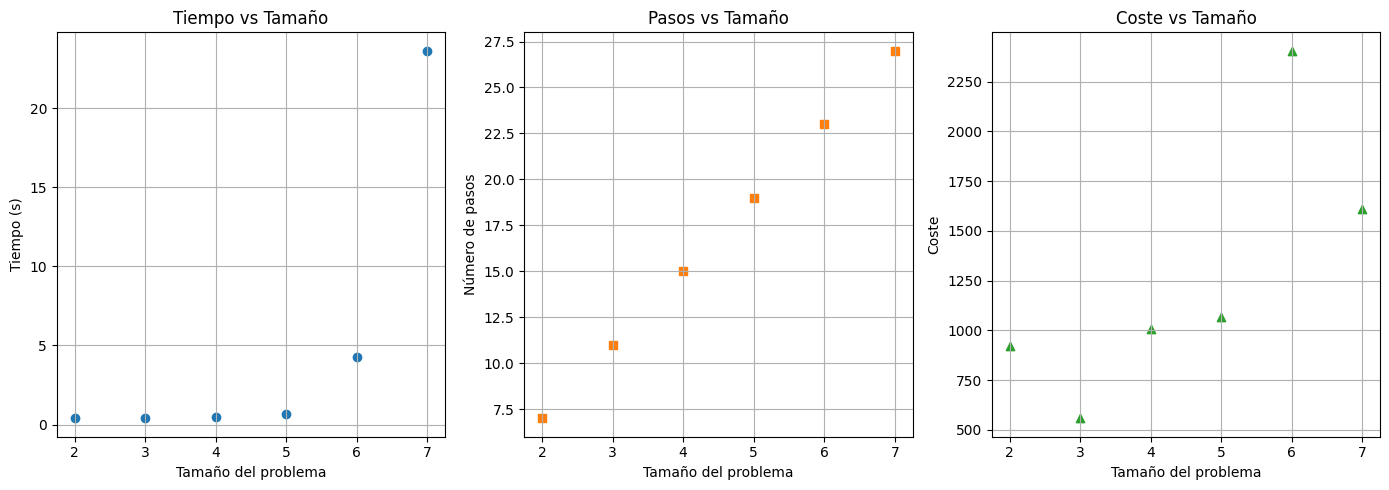

In [16]:
print("\n=== Resumen de resultados ===\n")
print(f"Tamaño máximo resuelto por {planner_name}: {max_size}")

csv_path = folder_path / f"Resultados/resultados_{planner_name.lower()}.csv"
df = pd.DataFrame({
    "Tamaño": sizes,
    "Tiempo (s)": times,
    "Pasos": steps_list,
    "Coste": costs
})
if csv_path.exists():
    old_df = pd.read_csv(csv_path)
    combined_df = pd.concat([old_df, df], ignore_index=True)
    final_df = combined_df.groupby('Tamaño', as_index=False)['Tiempo (s)'].mean()
    if 'Pasos' in combined_df.columns:
        pasos_df = combined_df.groupby('Tamaño', as_index=False)['Pasos'].max()
        final_df = final_df.merge(pasos_df, on='Tamaño')
    if 'Coste' in combined_df.columns:
        coste_df = combined_df.groupby('Tamaño', as_index=False)['Coste'].mean()
        final_df = final_df.merge(coste_df, on='Tamaño')
else:
    final_df = df
final_df.to_csv(csv_path, index=False)
print(f"Resultados de {planner_name} exportados a {csv_path}")

if sizes:
    df_display = pd.DataFrame({
        "Tamaño": sizes,
        "Tiempo (s)": times,
        "Pasos plan": steps_list,
        "Coste": costs,
        "Planificador": planner_name
    })
    display(df_display)

if outputs:
    max_idx = sizes.index(max_size)
    print(f"\nSalida fragmento para {planner_name} tamaño {max_size}:\n")
    print(outputs[max_idx])


# Cargar los datos desde el archivo CSV exportado
results = pd.read_csv(csv_path)

sizes = results['Tamaño']
times = results['Tiempo (s)']
steps = results['Pasos']

# Manejar la columna de coste si existe
if 'Coste' in results.columns:
    costs = results['Coste']
else:
    import numpy as np
    costs = np.full(len(sizes), np.nan)

fig, axs = plt.subplots(1, 3, figsize=(14, 5))

# Gráfico 1: Tiempo vs Tamaño (sin líneas entre puntos)
axs[0].scatter(sizes, times, marker='o', color='tab:blue')
axs[0].set_xlabel('Tamaño del problema')
axs[0].set_ylabel('Tiempo (s)')
axs[0].set_title('Tiempo vs Tamaño')
axs[0].grid(True)

# Gráfico 2: Pasos vs Tamaño (sin líneas entre puntos)
axs[1].scatter(sizes, steps, marker='s', color='tab:orange')
axs[1].set_xlabel('Tamaño del problema')
axs[1].set_ylabel('Número de pasos')
axs[1].set_title('Pasos vs Tamaño')
axs[1].grid(True)

# Gráfico 3: Coste vs Tamaño
axs[2].scatter(sizes, costs, marker='^', color='tab:green')
axs[2].set_xlabel('Tamaño del problema')
axs[2].set_ylabel('Coste')
axs[2].set_title('Coste vs Tamaño')
axs[2].grid(True)

plt.tight_layout()
plt.show()


# Bjolp

In [19]:
planner_name = "Fastdownard-seq-opt-bjolp"
sas_output_path = folder_path / "sas_plan"
# Remove --sas-file when using --alias
planner_cmd = [
    "/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/planificadores/downward.sif",
    "--alias", "seq-opt-bjolp", "--plan-file", str(sas_output_path),
    str(folder_path / "dron-domain.pddl")
    # problem_pddl will be appended later
]


max_time = 60
max_size = 0
sizes = []
times = []
steps_list = []
costs = []
outputs = []

size = 2
time_exceeded = False

if not problem_path.exists():
    os.makedirs(problem_path)

pbar = tqdm(desc="Resolviendo tamaños", unit="problema", position=0, leave=True)
while not time_exceeded:
    pbar.set_description(f"Tamaño actual: {size}")
    # Generar el problema con los parámetros actuales
    gen_cmd = f"python3 {folder_path}/generate_problem.py -d 1 -r 1 -l {size} -p {size} -c {size} -g {size} -v 0"
    os.system(gen_cmd)
    pddl_files = sorted(problem_path.glob("*.pddl"), key=os.path.getmtime, reverse=True)
    if not pddl_files:
        break
    problem_pddl = pddl_files[0]
    
    # Construir el comando completo para el planificador
    full_cmd = planner_cmd + [str(problem_pddl)]
    
    pddl_files = sorted(
        problem_path.glob("*.pddl"),
        key=os.path.getmtime,
        reverse=True
    )
    
    if not pddl_files:
        pbar.write("[ERROR] No se encontró el archivo .pddl generado.")
        break
    problem_pddl = pddl_files[0]

    pbar.set_postfix({"Planificador": planner_name, "Tamaño": size})

    start = time.time()
    try:
        result = subprocess.run(full_cmd, timeout=max_time, capture_output=True, text=True)
        elapsed = time.time() - start
        if result.returncode == 0:
    # Encontrar el último archivo sas_plan generado
            sas_files = sorted(
                folder_path.glob("sas_plan*"),
                key=lambda f: int(f.name.split(".")[-1]) if f.name != "sas_plan" else 0,
                reverse=True
            )
            
            if not sas_files:
                pbar.write("[ERROR] No se encontró archivo de plan")
                continue
            
            latest_sas = sas_files[0]
            
            # Leer y procesar el último plan
            plan_output = latest_sas.read_text().strip()
            
            # Contar pasos válidos
            num_steps = sum(
                1 for line in plan_output.split("\n")
                if line.strip() and not line.startswith(";") and "(" in line
            )
            
            # Extraer coste del plan
            plan_cost = None
            for line in plan_output.splitlines():
                if line.startswith(";") and "cost" in line:
                    try:
                        plan_cost = float(line.split("=")[1].split()[0].strip())
                    except (IndexError, ValueError):
                        pass
                    break
                    
            # Eliminar el archivo después de procesarlo
            sizes.append(size)
            times.append(elapsed)
            steps_list.append(num_steps - 1)
            costs.append(plan_cost)
            outputs.append(plan_output)  # guardar solo primeros 500 caracteres
            max_size = size
            
        else:
            pbar.write(f"[ERROR] Planificador {planner_name} falló para tamaño {size}.")
            print(f"Salida del planificador:\n{result.stdout}")
            time_exceeded = True
            break
    except Exception as e:
        pbar.write(f"[ERROR] Excepción al ejecutar el planificador: {e}")
        time_exceeded = True
        break
    pbar.update(1)
    size += 1
    os.remove(problem_pddl)
pbar.close()

print("\n=== Resumen de resultados ===\n")
print(f"Tamaño máximo resuelto por {planner_name}: {max_size}")

csv_path = folder_path / f"Resultados/resultados_{planner_name.lower()}.csv"
df = pd.DataFrame({
    "Tamaño": sizes,
    "Tiempo (s)": times,
    "Pasos": steps_list,
    "Coste": costs
})

df.to_csv(csv_path, index=False)
print(f"Resultados de {planner_name} exportados a {csv_path}")

if sizes:
    df_display = pd.DataFrame({
        "Tamaño": sizes,
        "Tiempo (s)": times,
        "Pasos plan": steps_list,
        "Coste": costs,
        "Planificador": planner_name
    })
    display(df_display)

if outputs:
    max_idx = sizes.index(max_size)
    print(f"\nSalida fragmento para {planner_name} tamaño {max_size}:\n")
    print(outputs[max_idx])



Resolviendo tamaños: 0problema [00:00, ?problema/s]

[ERROR] Excepción al ejecutar el planificador: Command '['/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/planificadores/downward.sif', '--alias', 'seq-opt-bjolp', '--plan-file', '/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/sas_plan', '/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/dron-domain.pddl', '/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/Problemas/drone_problem_d1_r1_l9_p9_c9_g9_ct2.pddl']' timed out after 60 seconds

=== Resumen de resultados ===

Tamaño máximo resuelto por Fastdownard-seq-opt-bjolp: 8
Resultados de Fastdownard-seq-opt-bjolp exportados a /home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/Resultados/resultados_fastdownard-seq-opt-bjolp.csv


,Tamaño,Tiempo (s),Pasos plan,Coste,Planificador
0,2,0.414153,7,616.0,Fastdownard-seq-opt-bjolp
1,3,0.409519,11,492.0,Fastdownard-seq-opt-bjolp
2,4,0.439545,15,1276.0,Fastdownard-seq-opt-bjolp
3,5,0.562980,19,1910.0,Fastdownard-seq-opt-bjolp
4,6,1.246791,23,1492.0,Fastdownard-seq-opt-bjolp
5,7,4.851044,27,1642.0,Fastdownard-seq-opt-bjolp
6,8,28.178730,31,3308.0,Fastdownard-seq-opt-bjolp



Salida fragmento para Fastdownard-seq-opt-bjolp tamaño 8:

(cargar_dron dron1 crate1 deposito)
(mover-dron dron1 deposito loc5)
(entregar person4 crate1 comida loc5 dron1)
(mover-dron dron1 loc5 deposito)
(cargar_dron dron1 crate4 deposito)
(mover-dron dron1 deposito loc5)
(entregar person4 crate4 medicina loc5 dron1)
(mover-dron dron1 loc5 deposito)
(cargar_dron dron1 crate2 deposito)
(mover-dron dron1 deposito loc3)
(entregar person8 crate2 comida loc3 dron1)
(mover-dron dron1 loc3 deposito)
(cargar_dron dron1 crate5 deposito)
(mover-dron dron1 deposito loc3)
(entregar person2 crate5 medicina loc3 dron1)
(mover-dron dron1 loc3 deposito)
(cargar_dron dron1 crate6 deposito)
(mover-dron dron1 deposito loc3)
(entregar person8 crate6 medicina loc3 dron1)
(mover-dron dron1 loc3 deposito)
(cargar_dron dron1 crate3 deposito)
(mover-dron dron1 deposito loc1)
(entregar person6 crate3 comida loc1 dron1)
(mover-dron dron1 loc1 deposito)
(cargar_dron dron1 crate7 deposito)
(mover-dron dron1 depo


=== Resumen de resultados ===

Tamaño máximo resuelto por Fastdownard-seq-opt-bjolp: 8
Resultados exportados a /home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/Resultados/resultados_fastdownard-seq-opt-bjolp.csv


,Tamaño,Tiempo (s),Pasos plan,Coste,Planificador
0,2,0.414153,7,616.0,Fastdownard-seq-opt-bjolp
1,3,0.409519,11,492.0,Fastdownard-seq-opt-bjolp
2,4,0.439545,15,1276.0,Fastdownard-seq-opt-bjolp
3,5,0.562980,19,1910.0,Fastdownard-seq-opt-bjolp
4,6,1.246791,23,1492.0,Fastdownard-seq-opt-bjolp
5,7,4.851044,27,1642.0,Fastdownard-seq-opt-bjolp
6,8,28.178730,31,3308.0,Fastdownard-seq-opt-bjolp


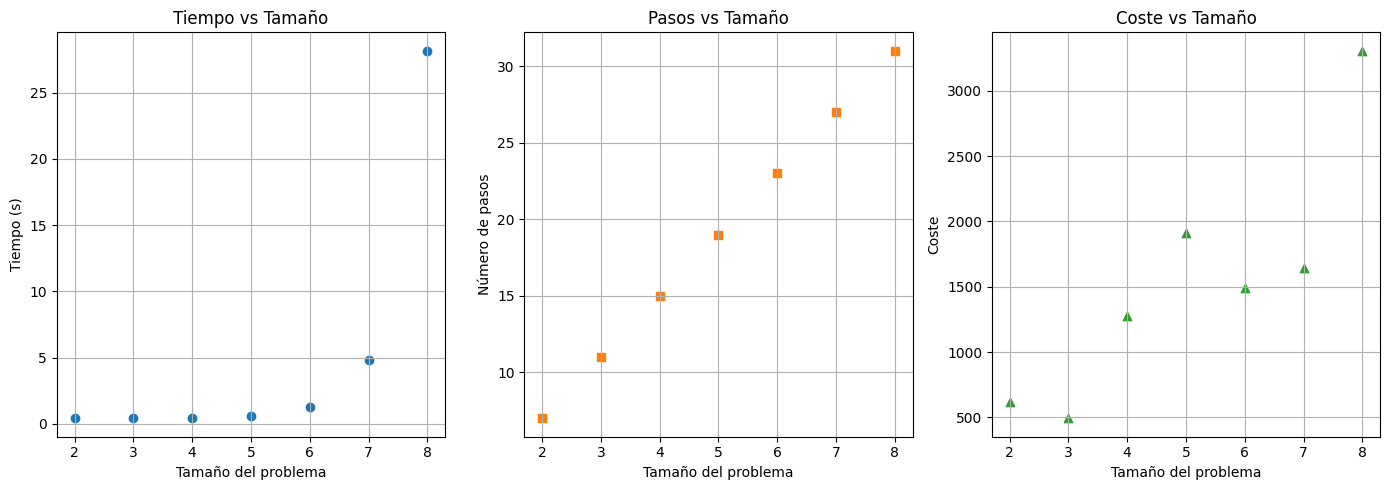

In [20]:
print("\n=== Resumen de resultados ===\n")
print(f"Tamaño máximo resuelto por {planner_name}: {max_size}")

df = pd.DataFrame({
    "Tamaño": sizes,
    "Tiempo (s)": times,
    "Pasos": steps_list,
    "Coste": costs
})

if csv_path.exists():
    old_df = pd.read_csv(csv_path)
    combined_df = pd.concat([old_df, df], ignore_index=True)
    tiempo_df = combined_df.groupby('Tamaño', as_index=False)['Tiempo (s)'].mean()
    pasos_df = combined_df.groupby('Tamaño', as_index=False)['Pasos'].max()
    if 'Coste' in combined_df.columns:
        coste_df = combined_df.groupby('Tamaño', as_index=False)['Coste'].mean()
        final_df = tiempo_df.merge(pasos_df, on='Tamaño').merge(coste_df, on='Tamaño')
    else:
        final_df = tiempo_df.merge(pasos_df, on='Tamaño')
else:
    final_df = df

final_df.to_csv(csv_path, index=False)
print(f"Resultados exportados a {csv_path}")

if len(sizes) > 0:
    df_display = pd.DataFrame({
        "Tamaño": sizes,
        "Tiempo (s)": times,
        "Pasos plan": steps_list,
        "Coste": costs,
        "Planificador": planner_name
    })
    display(df_display)

# Cargar los datos desde el archivo CSV exportado
results = pd.read_csv(csv_path)

sizes = results['Tamaño']
times = results['Tiempo (s)']
steps = results['Pasos']
if 'Coste' in results.columns:
    costs = results['Coste']
else:
    import numpy as np
    costs = np.full(len(sizes), np.nan)

fig, axs = plt.subplots(1, 3, figsize=(14, 5))

# Gráfico 1: Tiempo vs Tamaño (sin líneas entre puntos)
axs[0].scatter(sizes, times, marker='o', color='tab:blue')
axs[0].set_xlabel('Tamaño del problema')
axs[0].set_ylabel('Tiempo (s)')
axs[0].set_title('Tiempo vs Tamaño')
axs[0].grid(True)

# Gráfico 2: Pasos vs Tamaño (sin líneas entre puntos)
axs[1].scatter(sizes, steps, marker='s', color='tab:orange')
axs[1].set_xlabel('Tamaño del problema')
axs[1].set_ylabel('Número de pasos')
axs[1].set_title('Pasos vs Tamaño')
axs[1].grid(True)

# Gráfico 3: Coste vs Tamaño
axs[2].scatter(sizes, costs, marker='^', color='tab:green')
axs[2].set_xlabel('Tamaño del problema')
axs[2].set_ylabel('Coste')
axs[2].set_title('Coste vs Tamaño')
axs[2].grid(True)

plt.tight_layout()
plt.show()


# Stone Soup 2 Optimizing version

In [21]:
planner_name = "Fastdownard-seq-opt-fdss-2"
sas_output_path = folder_path / "sas_plan"
# Remove --sas-file when using --alias
planner_cmd = [
    "/home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/planificadores/downward.sif",
    "--alias", "seq-opt-fdss-2", "--plan-file", str(sas_output_path),
    str(folder_path / "dron-domain.pddl")
    # problem_pddl will be appended later
]


max_time = 60
max_size = 0
sizes = []
times = []
steps_list = []
costs = []
outputs = []

size = 2
time_exceeded = False

if not problem_path.exists():
    os.makedirs(problem_path)

pbar = tqdm(desc="Resolviendo tamaños", unit="problema", position=0, leave=True)
while not time_exceeded:
    pbar.set_description(f"Tamaño actual: {size}")
    # Generar el problema con los parámetros actuales
    gen_cmd = f"python3 {folder_path}/generate_problem.py -d 1 -r 1 -l {size} -p {size} -c {size} -g {size} -v 0"
    os.system(gen_cmd)
    pddl_files = sorted(problem_path.glob("*.pddl"), key=os.path.getmtime, reverse=True)
    if not pddl_files:
        break
    problem_pddl = pddl_files[0]
    
    # Construir el comando completo para el planificador
    full_cmd = planner_cmd + [str(problem_pddl)]
    
    pddl_files = sorted(
        problem_path.glob("*.pddl"),
        key=os.path.getmtime,
        reverse=True
    )
    
    if not pddl_files:
        pbar.write("[ERROR] No se encontró el archivo .pddl generado.")
        break
    problem_pddl = pddl_files[0]

    pbar.set_postfix({"Planificador": planner_name, "Tamaño": size})

    start = time.time()
    try:
        result = subprocess.run(full_cmd, timeout=max_time, capture_output=True, text=True)
        elapsed = time.time() - start
        if result.returncode == 0:
    # Encontrar el último archivo sas_plan generado
            sas_files = sorted(
                folder_path.glob("sas_plan*"),
                key=lambda f: int(f.name.split(".")[-1]) if f.name != "sas_plan" else 0,
                reverse=True
            )
            
            if not sas_files:
                pbar.write("[ERROR] No se encontró archivo de plan")
                continue
            
            latest_sas = sas_files[0]
            
            # Leer y procesar el último plan
            plan_output = latest_sas.read_text().strip()
            
            # Contar pasos válidos
            num_steps = sum(
                1 for line in plan_output.split("\n")
                if line.strip() and not line.startswith(";") and "(" in line
            )
            
            # Extraer coste del plan
            plan_cost = None
            for line in plan_output.splitlines():
                if line.startswith(";") and "cost" in line:
                    try:
                        plan_cost = float(line.split("=")[1].split()[0].strip())
                    except (IndexError, ValueError):
                        pass
                    break
                    
            # Eliminar el archivo después de procesarlo
            sizes.append(size)
            times.append(elapsed)
            steps_list.append(num_steps - 1)
            costs.append(plan_cost)
            outputs.append(plan_output)  # guardar solo primeros 500 caracteres
            max_size = size
            
        else:
            pbar.write(f"[ERROR] Planificador {planner_name} falló para tamaño {size}.")
            print(f"Salida del planificador:\n{result.stdout}")
            time_exceeded = True
            break
    except Exception as e:
        pbar.write(f"[ERROR] Excepción al ejecutar el planificador: {e}")
        time_exceeded = True
        break
    pbar.update(1)
    size += 1
    os.remove(problem_pddl)
pbar.close()

print("\n=== Resumen de resultados ===\n")
print(f"Tamaño máximo resuelto por {planner_name}: {max_size}")

csv_path = folder_path / f"Resultados/resultados_{planner_name.lower()}.csv"
df = pd.DataFrame({
    "Tamaño": sizes,
    "Tiempo (s)": times,
    "Pasos": steps_list,
    "Coste": costs
})

df.to_csv(csv_path, index=False)
print(f"Resultados de {planner_name} exportados a {csv_path}")

if sizes:
    df_display = pd.DataFrame({
        "Tamaño": sizes,
        "Tiempo (s)": times,
        "Pasos plan": steps_list,
        "Coste": costs,
        "Planificador": planner_name
    })
    display(df_display)

if outputs:
    max_idx = sizes.index(max_size)
    print(f"\nSalida fragmento para {planner_name} tamaño {max_size}:\n")
    print(outputs[max_idx])



Resolviendo tamaños: 0problema [00:00, ?problema/s]

[ERROR] Planificador Fastdownard-seq-opt-fdss-2 falló para tamaño 2.
Salida del planificador:
INFO     Running translator.
INFO     translator stdin: None
INFO     translator time limit: None
INFO     translator memory limit: None
INFO     translator command line string: /usr/bin/python3 /workspace/downward/builds/release/bin/translate/translate.py /home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/dron-domain.pddl /home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/Problemas/drone_problem_d1_r1_l2_p2_c2_g2_ct2.pddl --sas-file output.sas
Parsing...
Parsing: [0.000s CPU, 0.002s wall-clock]
Normalizing task... [0.000s CPU, 0.000s wall-clock]
Instantiating...
Generating Datalog program... [0.000s CPU, 0.000s wall-clock]
Normalizing Datalog program...
Normalizing Datalog program: [0.010s CPU, 0.004s wall-clock]
Preparing model... [0.000s CPU, 0.001s wall-clock]
Generated 69 rules.
Computing model... [0.000s CPU, 0.002s wall-clock]
156 releva


=== Resumen de resultados ===

Tamaño máximo resuelto por Fastdownard-seq-opt-fdss-2: 0
Resultados de Fastdownard-seq-opt-fdss-2 exportados a /home/javikugan/Documents/Universidad/Tercero/PlaniExt/Plani/Ejercicio2/2_2/Resultados/resultados_fastdownard-seq-opt-fdss-2.csv


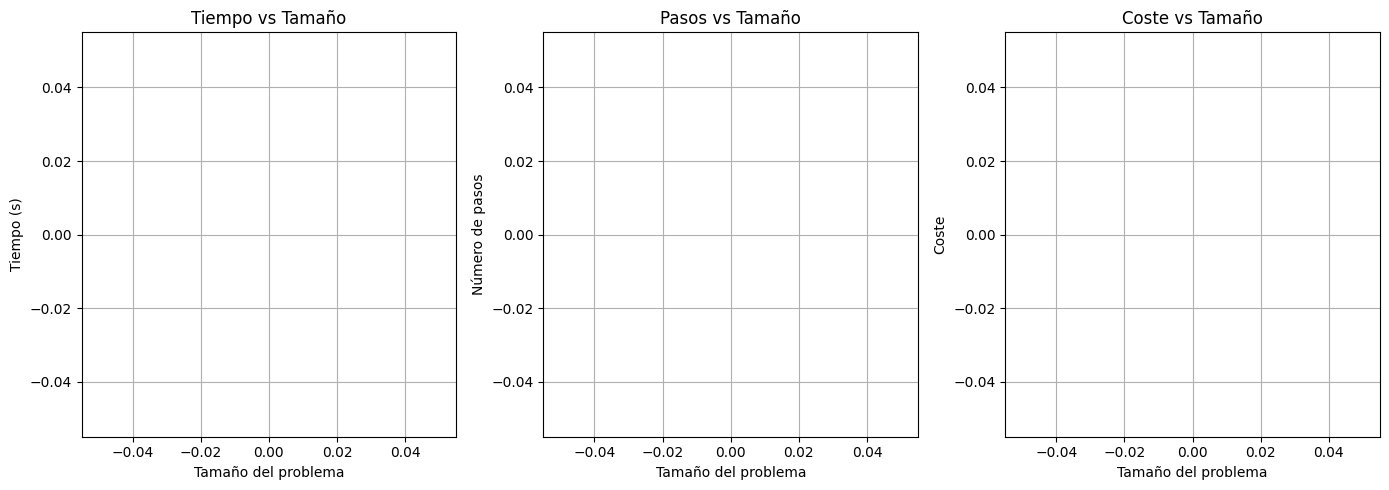

In [22]:
print("\n=== Resumen de resultados ===\n")
print(f"Tamaño máximo resuelto por {planner_name}: {max_size}")

csv_path = folder_path / f"Resultados/resultados_{planner_name.lower()}.csv"
df = pd.DataFrame({
    "Tamaño": sizes,
    "Tiempo (s)": times,
    "Pasos": steps_list
})
if csv_path.exists():
    old_df = pd.read_csv(csv_path)
    combined_df = pd.concat([old_df, df], ignore_index=True)
    final_df = combined_df.groupby('Tamaño', as_index=False)['Tiempo (s)'].mean()
    if 'Pasos' in combined_df.columns:
        pasos_df = combined_df.groupby('Tamaño', as_index=False)['Pasos'].max()
        final_df = final_df.merge(pasos_df, on='Tamaño')
else:
    final_df = df
final_df.to_csv(csv_path, index=False)
print(f"Resultados de {planner_name} exportados a {csv_path}")

if sizes:
    df_display = pd.DataFrame({
        "Tamaño": sizes,
        "Tiempo (s)": times,
        "Pasos plan": steps_list,
        "Planificador": planner_name
    })
    display(df_display)

if outputs:
    max_idx = sizes.index(max_size)
    print(f"\nSalida fragmento para {planner_name} tamaño {max_size}:\n")
    print(outputs[max_idx])


# Cargar los datos desde el archivo CSV exportado
results = pd.read_csv(csv_path)

sizes = results['Tamaño']
times = results['Tiempo (s)']
steps = results['Pasos']

# Manejar la columna de coste si existe
if 'Coste' in results.columns:
    costs = results['Coste']
else:
    import numpy as np
    costs = np.full(len(sizes), np.nan)

fig, axs = plt.subplots(1, 3, figsize=(14, 5))

# Gráfico 1: Tiempo vs Tamaño (sin líneas entre puntos)
axs[0].scatter(sizes, times, marker='o', color='tab:blue')


axs[0].set_xlabel('Tamaño del problema')
axs[0].set_ylabel('Tiempo (s)')
axs[0].set_title('Tiempo vs Tamaño')
axs[0].grid(True)

# Gráfico 2: Pasos vs Tamaño (sin líneas entre puntos)
axs[1].scatter(sizes, steps, marker='s', color='tab:orange')

axs[1].set_xlabel('Tamaño del problema')
axs[1].set_ylabel('Número de pasos')
axs[1].set_title('Pasos vs Tamaño')
axs[1].grid(True)

axs[2].scatter(sizes, costs, marker='^', color='tab:green')
axs[2].set_xlabel('Tamaño del problema')
axs[2].set_ylabel('Coste')
axs[2].set_title('Coste vs Tamaño')
axs[2].grid(True)

plt.tight_layout()
plt.show()



# Resultados Finales

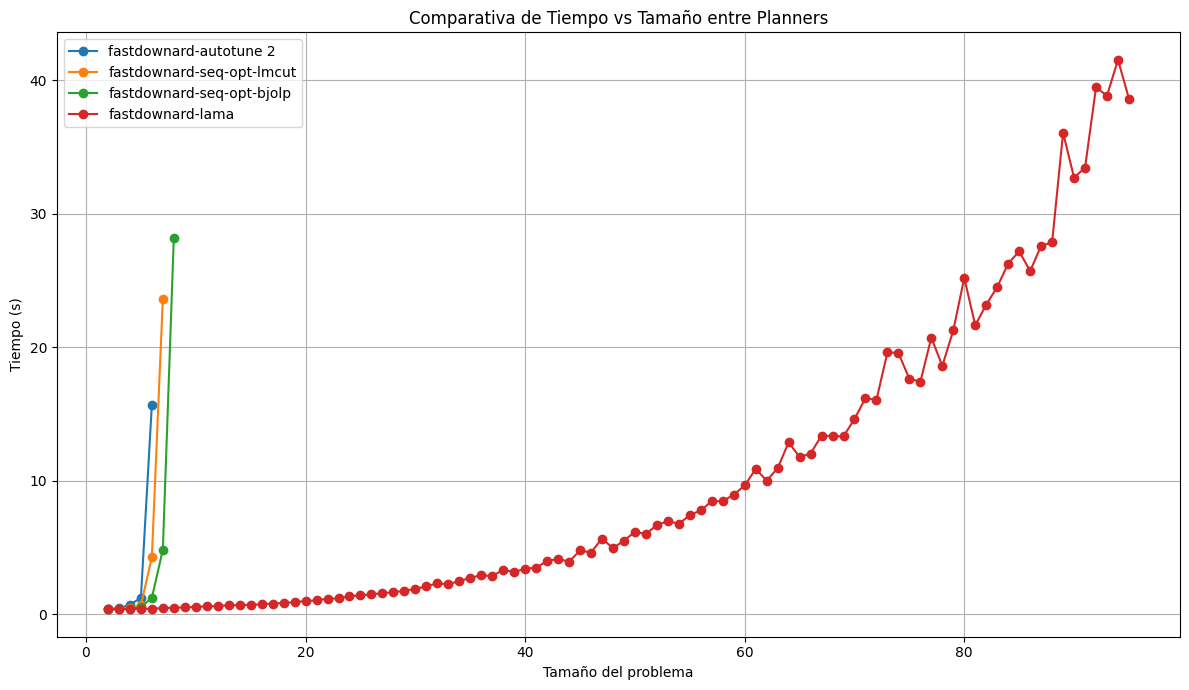

,Planner,Problemas resueltos,Tamaño máximo,Tiempo medio (s),Pasos medios,Coste medio
0,fastdownard-autotune 2,5,6,3.716941,15.0,1350.000000
1,fastdownard-seq-opt-lmcut,6,7,4.974968,17.0,1261.666667
2,fastdownard-seq-opt-bjolp,7,8,5.157538,19.0,1533.714286
3,fastdownard-lama,94,95,10.205171,193.0,14724.893617


In [23]:
# Buscar todos los archivos CSV de resultados en la carpeta Resultados
resultados_dir = folder_path / "Resultados"
csv_files = list(resultados_dir.glob("resultados_*.csv"))

# Diccionario para almacenar los datos de cada planner
comparativa = {}

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    # Extraer el nombre del planner del nombre del archivo
    planner = csv_file.stem.replace("resultados_", "")
    comparativa[planner] = df

# Graficar comparación de Tiempo vs Tamaño para cada planner
plt.figure(figsize=(12, 7))
for planner, df in comparativa.items():
    if not df.empty:
        plt.plot(df['Tamaño'], df['Tiempo (s)'], marker='o', label=planner)

plt.xlabel('Tamaño del problema')
plt.ylabel('Tiempo (s)')
plt.title('Comparativa de Tiempo vs Tamaño entre Planners')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Tabla de estadísticas para cada planner
stats = []
for planner, df in comparativa.items():
    if not df.empty:
        stats.append({
            "Planner": planner,
            "Problemas resueltos": len(df),
            "Tamaño máximo": df["Tamaño"].max(),
            "Tiempo medio (s)": df["Tiempo (s)"].mean(),
            "Pasos medios": df["Pasos"].mean() if "Pasos" in df.columns else None,
            "Coste medio": df["Coste"].mean() if "Coste" in df.columns else None
        })

stats_df = pd.DataFrame(stats)
display(stats_df)

In [24]:
# Definir el tipo de cada planificador/alias
planner_types = {
    "fastdownard-autotune 2": "portfolio",
    "fastdownard-seq-sat-fdss-2": "portfolio",
    "fastdownard-seq-opt-fdss-2": "portfolio",
    "fastdownard-seq-opt-lmcut": "óptimo",
    "fastdownard-seq-opt-bjolp": "óptimo",
    "fastdownard-lama": "anytime"
}

# Construir la tabla resumen
tabla = []
for planner, df in comparativa.items():
    if not df.empty:
        max_row = df.loc[df['Tamaño'].idxmax()]
        tabla.append({
            "Planificador/Alias": planner,
            "Tamaño máximo resuelto": max_row["Tamaño"],
            "Coste solución": max_row["Coste"] if "Coste" in df.columns else None,
            "Tipo": planner_types.get(planner, "desconocido")
        })

tabla_df = pd.DataFrame(tabla)
display(tabla_df)

,Planificador/Alias,Tamaño máximo resuelto,Coste solución,Tipo
0,fastdownard-autotune 2,6.0,1484.0,portfolio
1,fastdownard-seq-opt-lmcut,7.0,1608.0,óptimo
2,fastdownard-seq-opt-bjolp,8.0,3308.0,óptimo
3,fastdownard-lama,95.0,29456.0,anytime
